### Imports and directories

In [1]:
import numpy as np
import os
from oe_acute import trial_utils as tu
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import tqdm
import glob
from scipy.ndimage import gaussian_filter1d
from scipy.stats.stats import pearsonr 

import sys

In [2]:
#exp_path = '/mnt/cube/btheilma/experiments/B1240/block3/'
sort_path =  '/mnt/cube/btheilma/sorting/B1240/block3/'

stim_path = '/mnt/cube/srrudrar/experiments/MET_prediction_expt/'

exp_path1 = '/mnt/cube/srrudrar/experiments/B1240/block3/'
exp_path2 = '/mnt/cube/srrudrar/temporal_model/'

In [3]:
MNE_test_dset_pred = '/mnt/cube/srrudrar/temporal_model/stim_resp_signal/MNE_test_dset/' 
exp_path = '/mnt/cube/srrudrar/temporal_model/stim_resp_signal/'

MNE_test_dset_sig = '/mnt/cube/srrudrar/temporal_model/stim_resp_32x32_256/MNE_test_dset/'
exp_path_s = '/mnt/cube/srrudrar/temporal_model/stim_resp_32x32_256/'

MNE_test_dset_sig1 = '/mnt/cube/srrudrar/temporal_model/stim_resp_64x64_256/MNE_test_dset/'
exp_path_s1 = '/mnt/cube/srrudrar/temporal_model/stim_resp_64x64_256/'

In [4]:
ind = [165, 16, 191, 114, 12, 50, 96, 38, 211, 82, 130, 76, 142, 102, 107, 159, 156,
       66, 67, 206, 110, 93, 122, 125, 187, 68, 80, 81, 205, 147, 186, 63, 170, 51,
       2, 128, 41, 207, 35, 11, 21, 183, 112, 145, 53, 209, 57, 75, 31, 33]
units_to_process_all = np.load('/mnt/cube/srrudrar/temporal_model/units_to_process.npy')
clusters = list(units_to_process_all[ind])

### Functions

In [5]:
def predict_spiking_response(pfinal, stim_segs, sdim, n_trials=20):

    '''
    Given a pfinal parameter vector and stimulus segments, predict n_trials spike trains
    stim_segs is an array nsegs x ndim
    spikes is a binary array n_trials x nsegs
    TODO: Specify first order or second order model
    '''

    a = pfinal[0]
    h = pfinal[1:sdim+1]
    J = np.reshape(pfinal[-1*sdim**2:], (sdim, sdim))

    x = a + np.dot(stim_segs, h) + np.sum(stim_segs * (stim_segs.dot(J)), 1)
    probs = 1.0 / (1.0 + np.exp(x))
    spikes = np.less(np.random.rand(n_trials, len(probs)), probs).astype(int)
    return spikes

In [6]:
def predict_spiking_probability(pfinal, stim_segs, sdim, **kwargs):

    '''
    Given a pfinal parameter vector and stimulus segments, predict spiking probabilities
    stim_segs is an array nsegs x ndim
    spikes is a binary array n_trials x nsegs
    '''

    a = pfinal[0]
    h = pfinal[1:sdim+1]
    J = np.reshape(pfinal[-1*sdim**2:], (sdim, sdim))
    x = a + np.dot(stim_segs, h) + np.sum(stim_segs * (stim_segs.dot(J)), 1)
    probs = 1.0 / (1.0 + np.exp(x))
    return probs

def predict_spiking_prob_lin(pfinal, stim_segs, sdim, **kwargs):

    '''
    Given a pfinal parameter vector and stimulus segments, predict spiking probabilities
    stim_segs is an array nsegs x ndim
    spikes is a binary array n_trials x nsegs
    '''

    a = pfinal[0]
    h = pfinal[1:sdim+1]
    x = a + np.dot(stim_segs, h)
    probs = 1.0 / (1.0 + np.exp(x))
    return probs

In [7]:
def evaluate_prediction(pfinal, stims_test, resps_test, sdim, **kwargs):
    '''
    Given a vector of MNE parameters pfinal, predict spiking probabilities using stims_test and the 
    MNE model, and compare these to the given 'resps_test' using pearson correlation
    '''
    
    probs = predict_spiking_probability(pfinal, stims_test, sdim, **kwargs)
    corr = pearsonr(probs, resps_test.flatten())
    return probs, corr

def evaluate_pred_lin(pfinal, stims_test, resps_test, sdim, **kwargs):
    '''
    Given a vector of MNE parameters pfinal, predict spiking probabilities using stims_test and the 
    MNE model, and compare these to the given 'resps_test' using pearson correlation
    '''
    
    probs = predict_spiking_prob_lin(pfinal, stims_test, sdim, **kwargs)
    corr = pearsonr(probs, resps_test.flatten())
    return probs, corr

In [8]:
def correlate_gaussian_spiketrains(sp1, sp2, tau):
    '''
    Compute the correlation of two gaussian smoothed spike trains
    sp1, sp2 are lists of spike times, tau is the gaussian standard deviation
    '''
    diffmtx = sp2[:, np.newaxis] - sp1[np.newaxis, :]
    n1 = len(sp1)
    n2 = len(sp2)

    corr = np.sum(np.exp(-0.5*(diffmtx**2 / (2*tau**2)))*(tau*np.sqrt(np.pi)))
    return corr

### Corrs for all units

In [9]:
corrs_full = []
corrs_full_sig = []
corrs_full_sig1 = []
corrs_lin = []
corrs_lin_sig = []
corrs_lin_sig1 = []
units = []

for unit in clusters:
    # pred corr
    with open(os.path.join(MNE_test_dset_pred, 'unit-{}_MNE.pkl'.format(unit)), 'rb') as f:       #change
        test_dict = pickle.load(f)
    stims_test = test_dict['stims_test']
    resps_test = test_dict['resps_test']
    
    with open(os.path.join(exp_path, 'all_1_2_3_MNEs_random_test.pkl'), 'rb') as f:       #change                        
        pfinals = pickle.load(f)
    pfinal = pfinals[unit]
    
    probs, corr = evaluate_prediction(pfinal, stims_test, resps_test, sdim=256)
    probs_lin, corr_lin = evaluate_pred_lin(pfinal, stims_test, resps_test, sdim=256)
    
    
    # sig corr
    with open(os.path.join(MNE_test_dset_sig, 'unit-{}_MNE.pkl'.format(unit)), 'rb') as f:
        test_dict_sig = pickle.load(f)
    stims_test_sig = test_dict_sig['stims_test']
    resps_test_sig = test_dict_sig['resps_test']
    
    with open(os.path.join(exp_path_s, 'all_1_2_3_MNEs_random_test.pkl'), 'rb') as f:                          
        pfinals_sig = pickle.load(f)
    pfinal_sig = pfinals_sig[unit]
    
    probs_sig, corr_sig = evaluate_prediction(pfinal_sig, stims_test_sig, resps_test_sig, sdim=256)
    probs_lin_sig, corr_lin_sig = evaluate_pred_lin(pfinal_sig, stims_test_sig, resps_test_sig, sdim=256)
    
    
    # sig corr 1
    with open(os.path.join(MNE_test_dset_sig1, 'unit-{}_MNE.pkl'.format(unit)), 'rb') as f:
        test_dict_sig1 = pickle.load(f)
    stims_test_sig1 = test_dict_sig1['stims_test']
    resps_test_sig1 = test_dict_sig1['resps_test']
    
    with open(os.path.join(exp_path_s1, 'all_1_2_3_MNEs_random_test.pkl'), 'rb') as f:                          
        pfinals_sig1 = pickle.load(f)
    pfinal_sig1 = pfinals_sig1[unit]
    
    probs_sig1, corr_sig1 = evaluate_prediction(pfinal_sig1, stims_test_sig1, resps_test_sig1, sdim=256)
    probs_lin_sig1, corr_lin_sig1 = evaluate_pred_lin(pfinal_sig1, stims_test_sig1, resps_test_sig1, sdim=256)
    
    # form lists of correlations
    corrs_full.append(corr[0])
    corrs_lin.append(corr_lin[0])
    corrs_full_sig.append(corr_sig[0])
    corrs_lin_sig.append(corr_lin_sig[0])
    corrs_full_sig1.append(corr_sig1[0])
    corrs_lin_sig1.append(corr_lin_sig1[0])
    units.append(unit)

### Plots

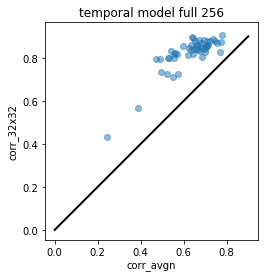

In [14]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(corrs_full, corrs_full_sig, alpha=0.5)
plt.plot([0, 0.9], [0, 0.9], color = 'black', linewidth = 2)
ax.set_aspect('equal', adjustable='box')
plt.title('temporal model full 256')
plt.xlabel('corr_avgn')
plt.ylabel('corr_32x32')
plt.show()

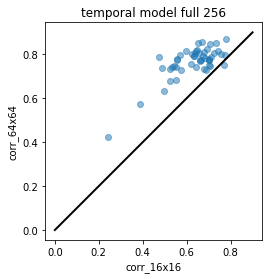

In [11]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(corrs_full, corrs_full_sig1, alpha=0.5)
plt.plot([0, 0.9], [0, 0.9], color = 'black', linewidth = 2)
ax.set_aspect('equal', adjustable='box')
plt.title('temporal model full 256')
plt.xlabel('corr_16x16')
plt.ylabel('corr_64x64')
plt.show()

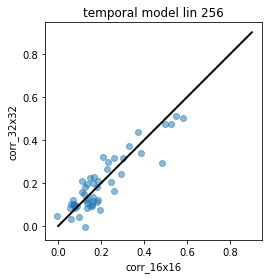

In [12]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(corrs_lin, corrs_lin_sig, alpha=0.5)
plt.plot([0, 0.9], [0, 0.9], color = 'black', linewidth = 2)
ax.set_aspect('equal', adjustable='box')
plt.title('temporal model lin 256')
plt.xlabel('corr_16x16')
plt.ylabel('corr_32x32')
plt.show()

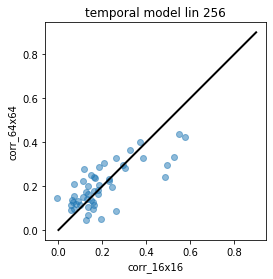

In [13]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(corrs_lin, corrs_lin_sig1, alpha=0.5)
plt.plot([0, 0.9], [0, 0.9], color = 'black', linewidth = 2)
ax.set_aspect('equal', adjustable='box')
plt.title('temporal model lin 256')
plt.xlabel('corr_16x16')
plt.ylabel('corr_64x64')
plt.show()

In [12]:
diag1 = np.array([0,0])
diag2 = np.array([0.9,0.9])
perp_dist = []
for i in range(len(corrs_full)):
    p = np.array([corrs_full_sig1[i],corrs_full[i]])
    d = np.cross(diag2 - diag1, p - diag1) / np.linalg.norm(diag2 - diag1)
    if corrs_full_sig1[i] > corrs_full[i]:
        perp_dist.append(-1*d)
    else:
        perp_dist.append(d)

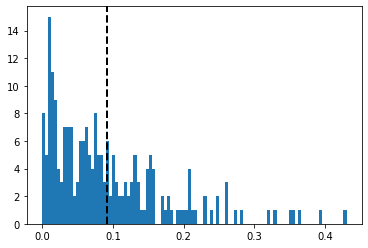

In [13]:
from scipy.stats import norm
import statistics

perp_dist = np.asarray(perp_dist)
plt.hist(perp_dist, 100)
  
# plotting mean line
plt.axvline(perp_dist.mean(), color='k', linestyle='dashed', linewidth=2)
  
# showing the plot
plt.show()

In [15]:
plt.plot(resp_test_sig1[0].flatten()[2750:3000], 'k', label='empirical response')
plt.plot(probs[0][2750:3000], 'b', label='response modeled w/signal')
#plt.legend()
#plt.xlabel('time bins')
#plt.ylabel('spiking probability')
#plt.grid()
plt.show()

NameError: name 'resp_test_sig1' is not defined

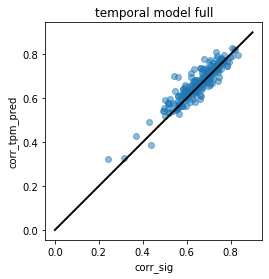

In [12]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(corrs_full_sig, corrs_full, alpha=0.5)
plt.plot([0, 0.9], [0, 0.9], color = 'black', linewidth = 2)
ax.set_aspect('equal', adjustable='box')
plt.title('temporal model full')
plt.xlabel('corr_sig')
plt.ylabel('corr_tpm_pred')
plt.show()

In [27]:
correlation_matrix = np.corrcoef(corrs_full_sig, corrs_full)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(r_squared)

0.731710017178755


In [28]:
import scipy
scipy.stats.ttest_rel(corrs_full_sig, corrs_full)

Ttest_relResult(statistic=-14.504881165931383, pvalue=1.2925806297406876e-33)

In [31]:
var = [(corrs_full[i] - corrs_full_sig[i])/corrs_full[i] for i in range(214)]

In [33]:
np.mean(corrs_full)

0.6712025049040009

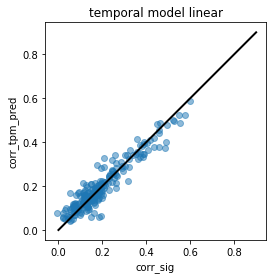

In [17]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(corrs_lin_sig, corrs_lin, alpha=0.5)
plt.plot([0, 0.9], [0, 0.9], color = 'black', linewidth = 2)
ax.set_aspect('equal', adjustable='box')
plt.title('temporal model linear')
plt.xlabel('corr_sig')
plt.ylabel('corr_tpm_pred')
plt.show()

In [23]:
import math
import numpy as np

# Function to find distance
def shortest_distance(x1, y1):      
    p1=np.array([0,0])
    p2=np.array([1,1])
    p3=np.array([x1,y1])
    d=np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
    #if x1>y1:
    #    d = d*-1
    return d

In [24]:
residual_full = []
residual_lin = []

for i in range(214):
    d_full = shortest_distance(corrs_full_sig[i], corrs_full[i])
    d_lin = shortest_distance(corrs_lin_sig[i], corrs_lin[i])
    residual_full.append(d_full)
    residual_lin.append(d_lin)

Text(0.5, 0, 'corr_tmp_pred')

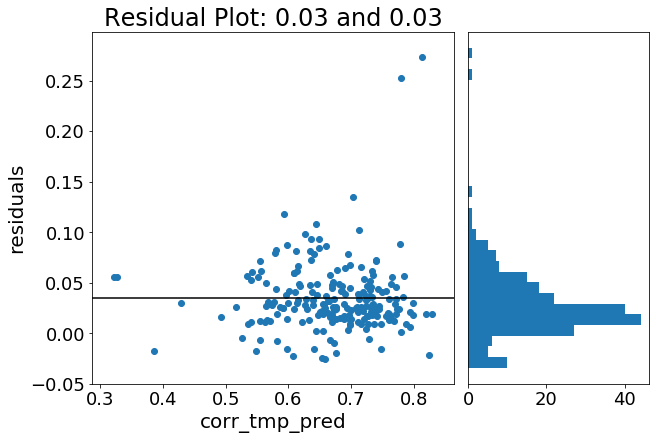

In [25]:
import matplotlib.gridspec as gridspec
from scipy.stats import norm

mu, std = norm.fit(residual_full)

fig = plt.figure(constrained_layout=True, figsize=(9, 6))
gs = fig.add_gridspec(1, 6)

ax_res = fig.add_subplot(gs[0, :4])
ax_res.scatter(corrs_full, residual_full)
ax_res.grid(False)
ax_res.axhline(y = mu, color='black', linestyle = '-')
ax_res.tick_params(axis='x', labelsize=18)
ax_res.tick_params(axis='y', labelsize=18)

ax_hist = fig.add_subplot(gs[0, 4:])
ax_hist.hist(residual_full, bins=30, orientation="horizontal");
ax_hist.grid(False)
#ax_hist.axhline(y = mu, color='black', linestyle = '-')
ax_hist.set_yticks([])
ax_hist.tick_params(axis='x', labelsize=18)

ax_res.set_title('Residual Plot: {:.2f} and {:.2f}'.format(mu, std), fontsize=24)
ax_res.set_ylabel('residuals', fontsize=20)
ax_res.set_xlabel('corr_tmp_pred', fontsize=20)

In [26]:
with open('/mnt/cube/srrudrar/temporal_model/figures/res_full_128.pkl', 'wb') as f:
    pickle.dump(residual_full, f)
with open('/mnt/cube/srrudrar/temporal_model/figures/res_lin_128.pkl', 'wb') as f:
    pickle.dump(residual_lin, f)

In [18]:
diag1 = np.array([0,0])
diag2 = np.array([0.9,0.9])
perp_dist = []
for i in range(len(corrs_full)):
    p = np.array([corrs_full_sig[i],corrs_full[i]])
    d = np.cross(diag2 - diag1, p - diag1) / np.linalg.norm(diag2 - diag1)
    if corrs_full_sig[i] > corrs_full[i]:
        perp_dist.append(-1*d)
    else:
        perp_dist.append(d)

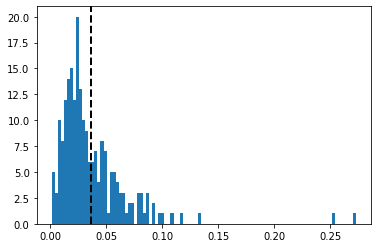

In [19]:
from scipy.stats import norm
import statistics

perp_dist = np.asarray(perp_dist)
plt.hist(perp_dist, 100)
  
# plotting mean line
plt.axvline(perp_dist.mean(), color='k', linestyle='dashed', linewidth=2)
  
# showing the plot
plt.show()

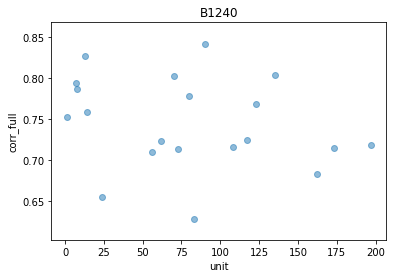

In [17]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(units, corrs_full, alpha=0.5)
#plt.plot([0, 0.6], [0, 0.6], color = 'black', linewidth = 2)
#ax.set_aspect('equal', adjustable='box')
plt.title('B1240')
plt.xlabel('unit')
plt.ylabel('corr_full')
plt.show()

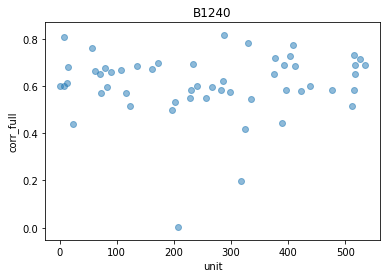

In [15]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(units, corrs_full, alpha=0.5)
#plt.plot([0, 0.6], [0, 0.6], color = 'black', linewidth = 2)
#ax.set_aspect('equal', adjustable='box')
plt.title('B1240')
plt.xlabel('unit')
plt.ylabel('corr_full')
plt.show()

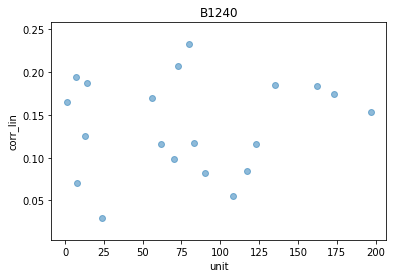

In [18]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(units, corrs_lin, alpha=0.5)
#plt.plot([0, 0.6], [0, 0.6], color = 'black', linewidth = 2)
#ax.set_aspect('equal', adjustable='box')
plt.title('B1240')
plt.xlabel('unit')
plt.ylabel('corr_lin')
plt.show()

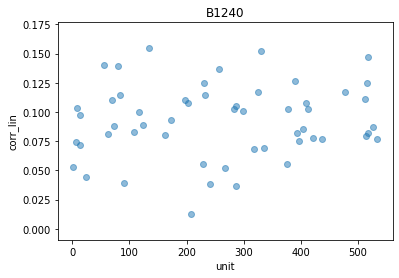

In [16]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(units, corrs_lin, alpha=0.5)
#plt.plot([0, 0.6], [0, 0.6], color = 'black', linewidth = 2)
#ax.set_aspect('equal', adjustable='box')
plt.title('B1240')
plt.xlabel('unit')
plt.ylabel('corr_lin')
plt.show()

In [9]:
for unit in units_to_process:
    with open(os.path.join(test_data_path, '{}_leave/stim_resp_test.pkl'.format(unit)), 'rb') as f:
        test_dict = pickle.load(f)

    stims_test = test_dict['stims_test']
    resps_test = test_dict['resps_test']

    with open(os.path.join(exp_path, 'all_mua_MNEs_leave_first_stim.pkl'), 'rb') as f:                             #change
        pfinals = pickle.load(f)

    pfinal = np.mean(pfinals[unit], axis = 0)
    probs, corr = evaluate_prediction(pfinal, stims_test, resps_test)
    probs_lin, corr_lin = evaluate_pred_lin(pfinal, stims_test, resps_test)

    prob_dict = {'probs':probs, 'probs_lin': probs_lin, 'corr': corr, 'corr_lin': corr_lin}
    
#    print(corr[0])
    print(corr_lin[0])
#
#    with open(os.path.join(output_path, 'spike_prob_{}.pkl'.format(unit)), 'wb') as f:
#        pickle.dump(prob_dict, f)

0.30059669808507755
0.34442423207352374
0.12489318569219118
0.257688643994984
0.19969372626022872
0.15035933421275122
0.19122007665414853
0.19510316663148372
0.14783440335160733
0.1641191563604661
0.19855549569136666
-0.01836060512280107
0.14753009360048858
0.1302675130677518
0.0489261920218622
0.12675123358142334
0.09555067127551342
0.031964404742560036


In [44]:
unit = 2
print(unit)
unit_pred = []

with open(os.path.join(test_data_path, '{}_leave/stim_resp_test.pkl'.format(unit)), 'rb') as f:
    test_dict = pickle.load(f)

stims_test = test_dict['stims_test']
resps_test = test_dict['resps_test']

with open(os.path.join(exp_path, 'all_good_MNEs_leave_first_stim.pkl'), 'rb') as f:
    pfinals = pickle.load(f)

pfinal_ = np.mean(pfinals[unit], axis = 0)
probs, corr = evaluate_prediction(pfinal, stims_test, resps_test)
probs_lin, corr_lin = evaluate_pred_lin(pfinal, stims_test, resps_test)

prob_dict = {'probs':probs, 'probs_lin': probs_lin, 'corr': corr, 'corr_lin': corr_lin}

with open(os.path.join(output_path, 'spike_prob_{}.pkl'.format(unit)), 'wb') as f:
    pickle.dump(prob_dict, f)

2


In [184]:
unit = 2
print(unit)
unit_pred = []

with open(os.path.join(resp_folder, 'G124-1 -1/good/{}_leave/stim_resp_test.pkl'.format(unit)), 'rb') as f:
    test_dict = pickle.load(f)


stim_segs = np.asarray([x.flatten() for x in stim_segs_list])

### normalize stim_segs
norm_stim_segs = (stim_segs - np.min(stim_segs)) / (np.max(stim_segs) - np.min(stim_segs))
norm_stim_segs_1 = stim_segs
norm_stim_segs_1 /= np.max(np.abs(norm_stim_segs_1),axis=0)

resp_segs = segs_dict['resp']

with open(os.path.join(exp_path, 'all_good_MNEs_leave_first_stim.pkl'), 'rb') as f:
    pfinals = pickle.load(f)

for jack, pfinal in enumerate(pfinals[unit]):
    probs, probs_lin, spikes = predict_spiking_probability_response(pfinal, norm_stim_segs_1)
    jack_dict = {'jack':jack, 'probs':probs, 'probs_lin':probs_lin, 'spikes':spikes}
    unit_pred.append(jack_dict)

#output_file = os.path.join(output_path, 'spike_probs_resp_leave_first_stim_unit_{}.pkl'.format(unit))    #change
#with open(output_file, 'wb') as f:
#    pickle.dump(unit_pred, f)    

2


In [171]:
np.min(stim_segs), np.max(stim_segs)

(-60.299668594499764, 54.87281572344237)

In [185]:
np.min(norm_stim_segs_1), np.max(norm_stim_segs_1)

(-1.0, 1.0)

In [187]:
np.min(full_segs), np.max(full_segs), np.mean(full_segs)

(0.0016390483694475478, 0.8520878222044108, 0.19046477869612202)

In [192]:
full_segs = unit_pred[0]['probs']
lin_segs = unit_pred[0]['probs_lin']

full_segs_1 = full_segs - 0.1

for i in full_segs_1:
    if i < 0:
        i = 0

norm_resp_segs = (resp_segs - np.min(resp_segs))/(np.max(resp_segs) - np.min(resp_segs))
#norm_full_segs = (full_segs - np.min(full_segs))/(np.max(full_segs) - np.min(full_segs))
#norm_lin_segs = (lin_segs - np.min(lin_segs))/(np.max(lin_segs) - np.min(lin_segs))


In [153]:
full = gaussian_filter1d(full_segs, 15)
#orig = gaussian_filter1d(norm_resp_segs[20:], 15)
orig = gaussian_filter1d(resp_segs[20:], 15)
lin = gaussian_filter1d(lin_segs, 15)

In [154]:
from scipy.stats.stats import pearsonr  

print(pearsonr(orig, full))
print(np.corrcoef(orig, full))

(0.42936575948509914, 1.882616663682709e-136)
[[1.         0.42936576]
 [0.42936576 1.        ]]


In [183]:
print(pearsonr(norm_resp_segs[20:], full_segs))
print(np.corrcoef(norm_resp_segs[20:], full_segs))

(-0.026367106015829547, 0.1463683592370846)
[[ 1.         -0.02636711]
 [-0.02636711  1.        ]]


In [180]:
print(pearsonr(orig, lin))
print(np.corrcoef(orig, lin))

(0.028056858810279136, 0.12220168424019877)
[[1.         0.02805686]
 [0.02805686 1.        ]]


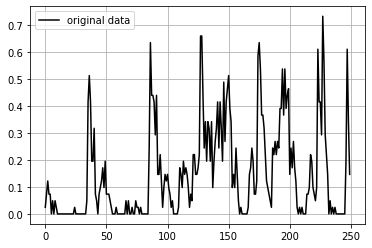

In [198]:
plt.plot(norm_resp_segs[20:][2750:3000], 'k', label='original data')
#plt.plot(full_segs_1[2700:2950], 'b', label='full data')
plt.legend()
plt.grid()
plt.show()

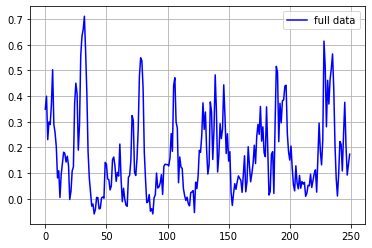

In [196]:
plt.plot(full_segs_1[2700:2950], 'b', label='full data')
plt.legend()
plt.grid()
plt.show()

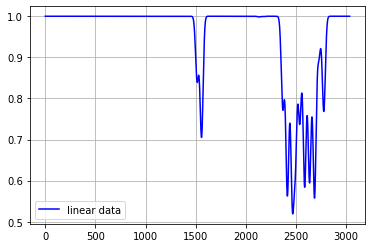

In [133]:
plt.plot(lin, 'b', label='linear data')
plt.legend()
plt.grid()
plt.show()

In [18]:
gaussian_filter1d([1.0, 2.0, 3.0, 4.0, 5.0], 1)
array([ 1.42704095,  2.06782203,  3.        ,  3.93217797,  4.57295905])
gaussian_filter1d([1.0, 2.0, 3.0, 4.0, 5.0], 4)
array([ 2.91948343,  2.95023502,  3.        ,  3.04976498,  3.08051657])
import matplotlib.pyplot as plt
np.random.seed(280490)
x = np.random.randn(101).cumsum()
y3 = gaussian_filter1d(x, 3)
y6 = gaussian_filter1d(x, 6)
plt.plot(x, 'k', label='original data')
plt.plot(y3, '--', label='filtered, sigma=3')
plt.plot(y6, ':', label='filtered, sigma=6')
plt.legend()
plt.grid()
plt.show()

1.0